Training on 5440 samples, testing on 1360 samples.

--- Training and Evaluating Models ---
Successfully evaluated: Logistic Regression
Successfully evaluated: K-Nearest Neighbors
Successfully evaluated: Naive Bayes (Gaussian)
Successfully evaluated: Support Vector Machine
Successfully evaluated: Decision Tree
Successfully evaluated: Random Forest
Successfully evaluated: Gradient Boosting


C:\Users\ok\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Successfully evaluated: AdaBoost
Successfully evaluated: Neural Network (MLP)
Failed to evaluate XGBoost: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Fertile' 'Non Fertility']
--------------------------------------

--- Model Comparison Results ---
                 Model  Accuracy  F1-Score
         Decision Tree  1.000000  1.000000
         Random Forest  1.000000  1.000000
     Gradient Boosting  1.000000  1.000000
              AdaBoost  1.000000  1.000000
   Logistic Regression  0.997059  0.997061
  Neural Network (MLP)  0.993382  0.993390
Support Vector Machine  0.992647  0.992636
   K-Nearest Neighbors  0.977206  0.977341
Naive Bayes (Gaussian)  0.797794  0.806695
--------------------------------



C:\Users\ok\AppData\Local\Temp\ipykernel_3412\4160539193.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Saved comparison plot to model_comparison_f1_score.png


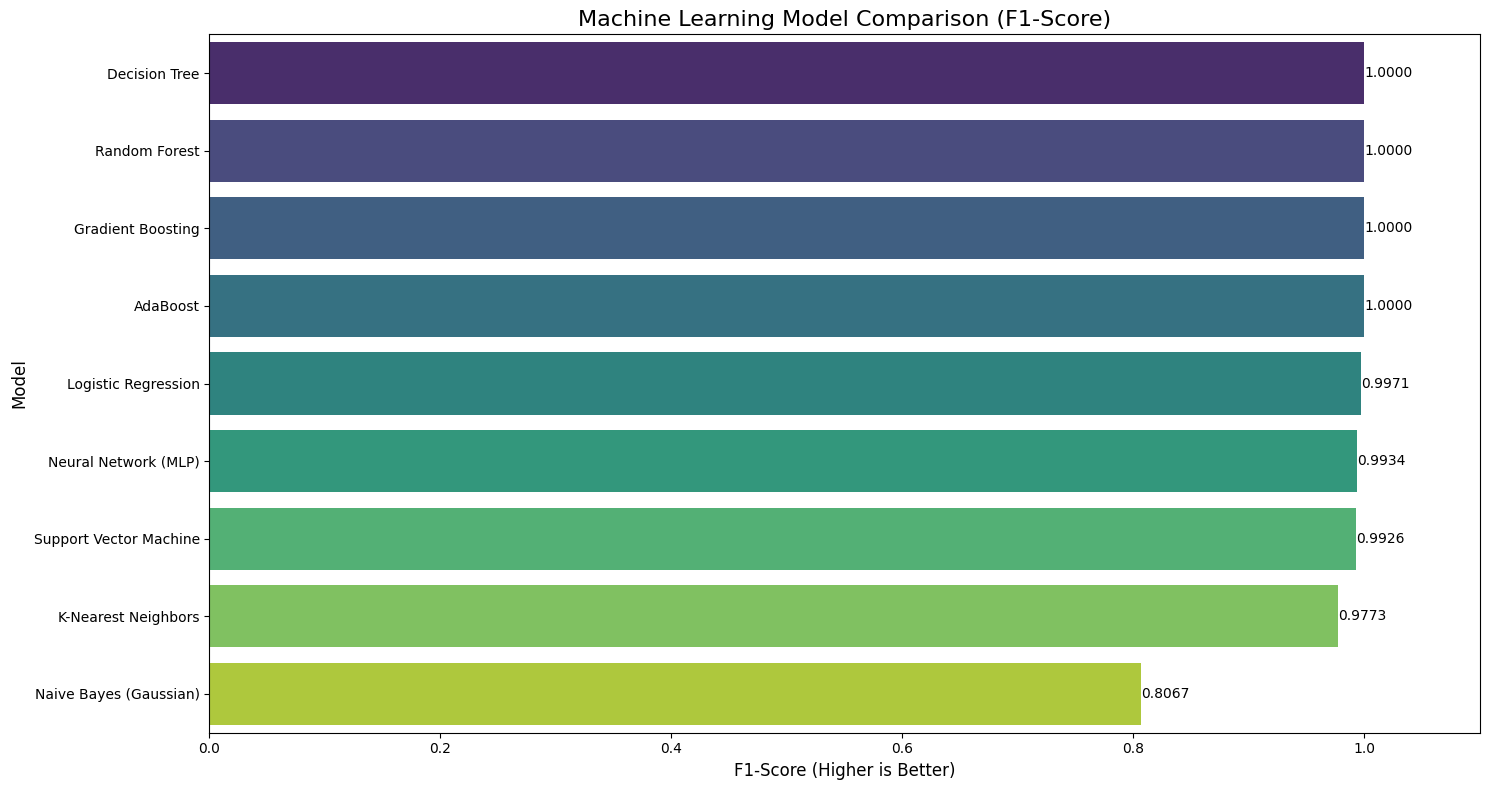

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# --- Import all the models ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    print("XGBoost is not installed. Skipping XGBoost model.")
    XGB_AVAILABLE = False

# --- 1. Load and Prepare Data ---

try:
    df = pd.read_csv("Soil_data.csv")
except FileNotFoundError:
    print("Error: Soil_data.csv not found. Please make sure the file is in the same directory.")
    exit()

# !!! IMPORTANT: CHANGE 'Fertility' TO YOUR ACTUAL TARGET COLUMN NAME !!!
# This is the column that says "Healthy" or "Unhealthy" (e.g., as 1 or 0)
TARGET_COLUMN = 'Fertility_Category' 

if TARGET_COLUMN not in df.columns:
    print(f"Error: Target column '{TARGET_COLUMN}' not found in the CSV.")
    print(f"Available columns are: {df.columns.tolist()}")
    # As a guess, let's assume the last column is the target
    TARGET_COLUMN = df.columns[-1]
    print(f"Assuming target column is: '{TARGET_COLUMN}'")


# Separate features (X) and target (y)
y = df[TARGET_COLUMN]
X = df.drop(TARGET_COLUMN, axis=1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
# This is crucial for models like SVM, Logistic Regression, KNN, and MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples.")

# --- 2. Define All Models to Compare ---

# We use a dictionary to store all models for easy iteration
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network (MLP)": MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,50), alpha=0.001, random_state=42)
}

# Add XGBoost only if it was successfully imported
if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# --- 3. Train and Evaluate All Models ---

# We will store the results in a list
results = []

print("\n--- Training and Evaluating Models ---")

for name, model in models.items():
    try:
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') # 'weighted' handles class imbalance
        
        # Store results
        results.append({
            "Model": name,
            "Accuracy": accuracy,
            "F1-Score": f1
        })
        
        print(f"Successfully evaluated: {name}")
        
    except Exception as e:
        print(f"Failed to evaluate {name}: {e}")

print("--------------------------------------\n")

# --- 4. Compare Results ---

# Convert the results list to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort the DataFrame by F1-Score (or 'Accuracy' if you prefer)
results_df = results_df.sort_values(by="F1-Score", ascending=False)

# Display the results table
print("--- Model Comparison Results ---")
print(results_df.to_string(index=False))
print("--------------------------------\n")

# --- 5. Plot the Results ---

if not results_df.empty:
    plt.figure(figsize=(15, 8))
    
    # Use seaborn for a nice bar plot
    ax = sns.barplot(
        x="F1-Score", 
        y="Model", 
        data=results_df, 
        palette="viridis",
        orient='h' # Horizontal bar plot
    )
    
    plt.title('Machine Learning Model Comparison (F1-Score)', fontsize=16)
    plt.xlabel('F1-Score (Higher is Better)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.xlim(0, 1.1) # Set x-axis limit from 0 to 1.1 (F1-scores are 0-1)
    
    # Add the F1-score value labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f') # Format to 4 decimal places

    plt.tight_layout()
    # Save the plot to a file
    plt.savefig("model_comparison_f1_score.png")
    print("Saved comparison plot to model_comparison_f1_score.png")

else:
    print("No models were successfully evaluated. Skipping plot.")